# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [201]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN ,Input


## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

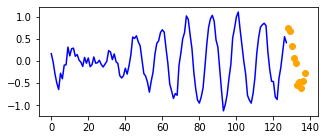

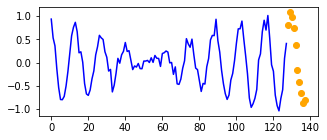

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [3]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

In [28]:
print(X.shape)
print(Y.shape)
print(X[0])
print(Y[0])

(1000, 128, 1)
(1000, 10, 1)
[[ 1.67851679e-01]
 [-1.49147717e-02]
 [-2.87128158e-01]
 [-4.95270896e-01]
 [-6.39140987e-01]
 [-2.74092878e-01]
 [-3.97587745e-01]
 [-9.06528408e-02]
 [-8.39834637e-02]
 [ 3.16094480e-01]
 [ 1.18608001e-01]
 [ 2.79278233e-01]
 [ 2.91331077e-01]
 [ 1.08574351e-01]
 [ 1.47504766e-01]
 [ 2.41033984e-02]
 [-2.48567041e-02]
 [-1.18996919e-01]
 [ 8.37736164e-02]
 [-4.76291011e-02]
 [ 7.03855096e-02]
 [-1.25288870e-01]
 [-8.25894554e-02]
 [ 9.26520384e-02]
 [-4.70369484e-02]
 [-3.59742023e-02]
 [ 1.86820793e-02]
 [-7.43884593e-02]
 [-1.33151102e-01]
 [-7.07661013e-02]
 [-2.72518845e-03]
 [ 2.35970299e-01]
 [ 2.04560774e-01]
 [ 3.33958338e-02]
 [ 1.62045771e-01]
 [-1.31903316e-02]
 [-5.55490755e-02]
 [-3.25676727e-01]
 [-3.80425410e-01]
 [-3.32371993e-01]
 [-1.60589317e-01]
 [-2.93304023e-01]
 [-1.04418306e-01]
 [ 1.42600416e-01]
 [ 5.43108439e-01]
 [ 5.11068025e-01]
 [ 5.70762161e-01]
 [ 4.34043010e-01]
 [ 3.47442187e-01]
 [ 4.09389560e-02]
 [-2.79625466e-01]
 [

### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

In [154]:
import numpy as np
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout,Convolution1D,SimpleRNN
from tensorflow.keras.optimizers import SGD
tf.__version__

'2.4.0'

In [33]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

In [105]:
model = Sequential()
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal"))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal"))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal"))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal"))
model.add(Dense(1,activation="linear"))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))




# Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
=================================================================
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________

In [106]:
trainings_data =X[:800]
trainings_class =Y[:800]
valid_data =X[800:]
valid_class = Y[800:]
print(trainings_data.shape)

# Optimierer
eta = 0.01                  # learning rate
wdecay = 0.1/np.shape(trainings_data)[0]    # weight decay
sgd = SGD(lr=eta, decay=wdecay)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = sgd,
              metrics=['mse'])

history = model.fit(trainings_data,trainings_class,
                    
          batch_size=10,
          epochs=10, 
          validation_data=(valid_data,valid_class))



(800, 128, 1)
Epoch 1/10
80/80 [==============================] - 1s 9ms/step - loss: 0.2303 - mse: 0.2303 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 2/10
80/80 [==============================] - 1s 7ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 3/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 4/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 5/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 6/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 7/10
80/80 [==============================] - 1s 7ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/10
80/80 [==============================] - 0s 6ms/step - loss: 0.03

In [107]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_83 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_84 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_85 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_14 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_12 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

array([[ 0.6451486 ],
       [ 0.44185314],
       [ 0.16441046],
       [-0.0978705 ],
       [-0.3187952 ],
       [-0.4440521 ],
       [-0.46691564],
       [-0.34525388],
       [-0.18720871],
       [ 0.02227302]], dtype=float32)

### Make repeated predictions



Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [ ]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model1.predict(x_test).reshape(-1)#Predicts 10 value

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.  

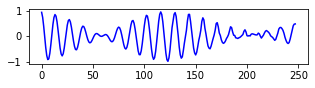

In [149]:
x_training,y_training = gen_data(size=1,noise =0.0)
for i in range(0,12):
    data = model.predict(x_training)
    x_training = np.concatenate((x_training, data), axis=1)
plt.figure(num=None, figsize=(5,1))  
plt.plot(range(0, x_training[0].shape[0]),x_training[0],'b-')
plt.show()

## B) 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)

Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [140]:
model = Sequential()
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal",dilation_rate=1))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal",dilation_rate=2))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal",dilation_rate=4))
model.add(Convolution1D(32, kernel_size=(5),activation='relu',batch_input_shape=(None, None, 1),padding="causal",dilation_rate=8))
model.add(Dense(1,activation="linear"))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

In [141]:
trainings_data =X[:800]
trainings_class =Y[:800]
valid_data =X[800:]
valid_class = Y[800:]
print(trainings_data.shape)

# Optimierer
eta = 0.01                  # learning rate
wdecay = 0.1/np.shape(trainings_data)[0]    # weight decay
sgd = SGD(lr=eta, decay=wdecay)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = sgd,
              metrics=['mse'])

history = model.fit(trainings_data,trainings_class,
                    
          batch_size=10,
          epochs=10, 
          validation_data=(valid_data,valid_class))

(800, 128, 1)
Epoch 1/10
80/80 [==============================] - 2s 9ms/step - loss: 0.2779 - mse: 0.2779 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 2/10
80/80 [==============================] - 1s 6ms/step - loss: 0.1757 - mse: 0.1757 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 3/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 4/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 5/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 7/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 8/10
80/80 [==============================] - 0s 6ms/step - loss: 0.01

In [142]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_95 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_96 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_97 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_15 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

### Make repeated predictions
As in A) make preaded preditions on noise less data.

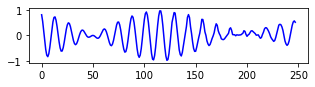

In [151]:
x_training,y_training = gen_data(size=1,noise =0.0)
for i in range(0,12):
    data = model.predict(x_training)
    x_training = np.concatenate((x_training, data), axis=1)
plt.figure(num=None, figsize=(5,1))  
plt.plot(range(0, x_training[0].shape[0]),x_training[0],'b-')
plt.show()

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [291]:
model = Sequential()
model.add(SimpleRNN(12,batch_input_shape=(None,None,1),input_shape=(1,1),return_sequences = True))
model.add(SimpleRNN(12,batch_input_shape=(None,None,1),input_shape=(1,2),return_sequences = True))
model.add(SimpleRNN(12,batch_input_shape=(None,None,1),input_shape=(1,4),return_sequences = True))
model.add(SimpleRNN(12,batch_input_shape=(None,None,1),input_shape=(1,8),return_sequences = True))
#model.add(SimpleRNN(12,batch_input_shape=(None,None,1),return_sequences = True))
model.add(Dense(1,activation="linear"))

model.add(Lambda(slice, arguments={'slice_length':look_ahead}))
# Optimierer
eta = 0.01                  # learning rate
wdecay = 0.1/np.shape(trainings_data)[0]    # weight decay
sgd = SGD(lr=eta, decay=wdecay)

model.compile(loss = "mse",optimizer = sgd)
model.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_69 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
simple_rnn_70 (SimpleRNN)    (None, None, 12)          300       
_________________________________________________________________
simple_rnn_71 (SimpleRNN)    (None, None, 12)          300       
_________________________________________________________________
simple_rnn_72 (SimpleRNN)    (None, None, 12)          300       
_________________________________________________________________
dense_63 (Dense)             (None, None, 1)           13        
_________________________________________________________________
lambda_54 (Lambda)           (None, None, 1)           0         
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
__________________________________________________

In [292]:
trainings_data =X[:800]
trainings_class =Y[:800]
valid_data =X[800:]
valid_class = Y[800:]
print(trainings_data.shape)

history = model.fit(trainings_data,trainings_class,
                    
          batch_size=10,
          epochs=10, 
          validation_data=(valid_data,valid_class))

(800, 128, 1)
Epoch 1/10
80/80 [==============================] - 8s 61ms/step - loss: 0.1057 - val_loss: 0.0505
Epoch 2/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0487 - val_loss: 0.0380
Epoch 3/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0383 - val_loss: 0.0319
Epoch 4/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0333 - val_loss: 0.0284
Epoch 5/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0287 - val_loss: 0.0264
Epoch 6/10
80/80 [==============================] - 4s 54ms/step - loss: 0.0257 - val_loss: 0.0247
Epoch 7/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 8/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0238 - val_loss: 0.0230
Epoch 9/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0226 - val_loss: 0.0249
Epoch 10/10
80/80 [==============================] - 4s 53ms/step - loss: 0.0226 - val_loss: 0.

### Make repeated predictions
As in A) make preaded preditions on noise less data.

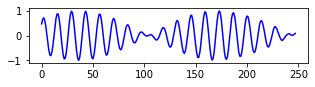

In [270]:
x_training,y_training = gen_data(size=1,noise =0.0)
for i in range(0,12):
    data = model.predict(x_training)
    x_training = np.concatenate((x_training, data), axis=1)
plt.figure(num=None, figsize=(5,1))  
plt.plot(range(0, x_training[0].shape[0]),x_training[0],'b-')
plt.show()

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [303]:
model = Sequential()
model.add(LSTM(24,batch_input_shape=(None,None,1),input_shape=(1,1),return_sequences= True))
#model.add(LSTM(24,batch_input_shape=(None,None,1),input_shape=(1,2),return_sequences= True))
#model.add(LSTM(24,batch_input_shape=(None,None,1),input_shape=(1,4),return_sequences= True))
#model.add(LSTM(24,batch_input_shape=(None,None,1),input_shape=(1,8),return_sequences= True))
model.add(Dense(1,activation="linear"))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

In [304]:
trainings_data =X[:800]
trainings_class =Y[:800]
valid_data =X[800:]
valid_class = Y[800:]
print(trainings_data.shape)

# Optimierer
eta = 0.04                  # learning rate
wdecay = 0.1/np.shape(trainings_data)[0]    # weight decay
sgd = SGD(lr=eta, decay=wdecay)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = sgd,
              metrics=['mse'])

history = model.fit(trainings_data,trainings_class,
                    
          batch_size=10,
          epochs=10, 
          validation_data=(valid_data,valid_class))

(800, 128, 1)
Epoch 1/10
80/80 [==============================] - 4s 27ms/step - loss: 0.2911 - mse: 0.2911 - val_loss: 0.0941 - val_mse: 0.0941
Epoch 2/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 3/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 4/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 5/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 6/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 7/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 8/10
80/80 [==============================] - 2s 20ms/step - lo

In [276]:
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
dense_58 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_49 (Lambda)           (None, None, 1)           0         
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_training,y_training = gen_data(size=1,noise =0.0)
for i in range(0,12):
    data = model.predict(x_training)
    x_training = np.concatenate((x_training, data), axis=1)
plt.figure(num=None, figsize=(5,1))  
plt.plot(range(0, x_training[0].shape[0]),x_training[0],'b-')
plt.show()